# Setup

Don't change this cell; setup should remain the same for all data series.

In [1]:
#Imports
import glob, math
import numpy as np
import pandas as pd
import lmfit as lf
import statistics as s
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from scipy import signal as sig

#Import custom library included in this repository
from R76Tools import *

#Use local mplstyle
plt.style.use('./default.mplstyle')

# Set up possible data paths
frittspath = "/data/chocula/fritts/data/k100proc/midasrq/byseries/"
neogpath = "/data/chocula/neog/rq/"

## Data Selection
Change this cell in order to select and label data.

In [2]:
ser = ["07221119_1016"]
lab = ["-81.5V"]
datapath = frittspath #The data is in this folder. change as needed.

# Load and Plot
Don't change these cells unless you are experiencing issues with the selected binning. (In that case, change the first line of the second cell.)

In [3]:
#Start by importing and organizing our data
e=[]; z=[];
for series in ser:
    filelist = glob.glob(datapath+series+"/umn*.root")
    e_chain,z_chain = makechain(filelist,fittingfilters)
    e.append(e_chain);z.append(z_chain)

for i,x in enumerate(z):
    z[i] = pd.concat([x,e[i]],axis=1)
    
for x in z:
    x['crand'] = crand(x)
    x['pt_keV'] = pt_keV(x)
    x['cam'] =  cam(x)
    x['cphi1'] = cphi1(x)
    x['PSUMbs'] = PSUMbs(x)
    

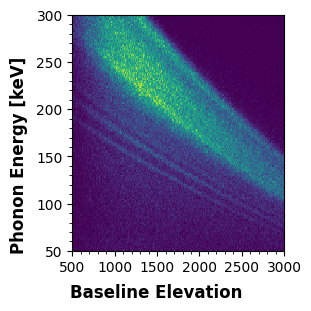

In [31]:
bins = [np.linspace(500,3000,200),np.linspace(50,300,150)]
    
#Plot
n = len(ser); vert = math.ceil(np.sqrt(n)); hor = math.ceil(n/math.ceil(np.sqrt(n)))
fig,ax = plt.subplots(vert,hor,figsize=(3*hor,3*vert),sharey=True)
try:
    for i,axarray in enumerate(ax):
        for j,axis in enumerate(axarray):
            k = j + i*len(axarray)
            if k < len(z): #do nothing if we have an empty corner.
                axis.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['pt_keV'][~z[k]['crand']],bins=bins)
except TypeError: #Case for when there is only one entry.
    if len(z) == 1:
        k = 0 #We could squish z from an array to its entry but that gets complicated later on.
        ax.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['pt_keV'][~z[k]['crand']],bins=bins)
    else:
        raise SizeError("axes could not be enumerated twice but Z had more than one entry... fix it nerd!!")

fig.supxlabel("Baseline Elevation"); fig.supylabel("Phonon Energy [keV]")
plt.show()

## Define points to fit to
Change the first two lines of this cell until you get the lines looking right in the second.

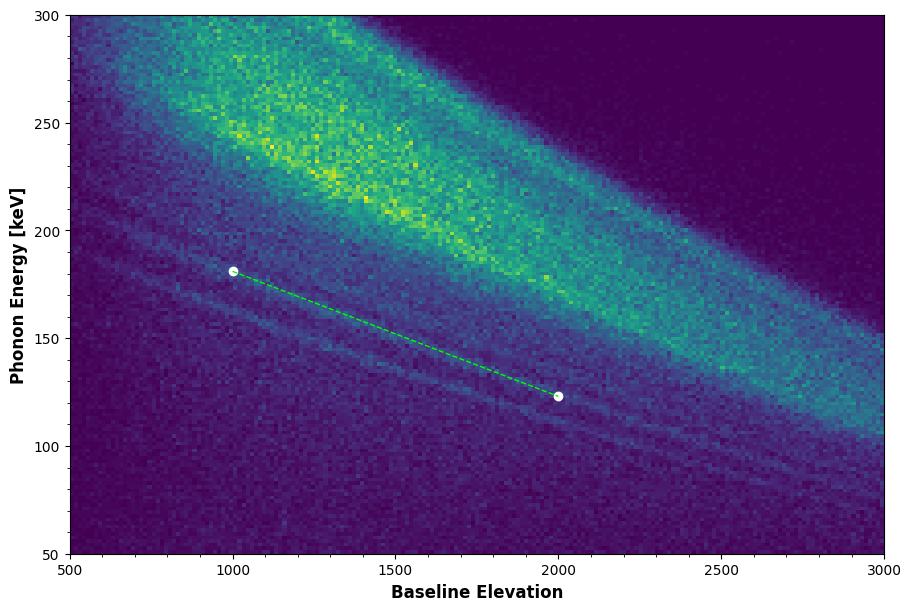

In [80]:
points = [[1000,181],[2000,123]] #Some points along one of the lines
x = z[0] #Pick one of the entries in z to use

fig = plt.figure()
plt.hist2d(x["PSUMbs"][~x["crand"]]-18000, x["pt_keV"][~x["crand"]],bins=bins)
             #bins=[np.linspace(-50,2500,200),np.linspace(50,200,150)])
m = (points[1][1]-points[0][1])/(points[1][0]-points[0][0]); b = points[0][1] - points[0][0]*m
x = np.linspace(points[0][0],points[1][0],1000)
plt.scatter([points[0][0],points[1][0]],[points[0][1],points[1][1]],color='white')
plt.plot(x,m*x+b,color='lime')
plt.xlabel("Baseline Elevation")
plt.ylabel("Phonon Energy [keV]")
plt.show()

## Check baseline correction

Don't change these cells; they are here to show you the results of your correction only.

In [81]:
for x in z:
    x['bscorr_man'] = bscorr(x,m/b)

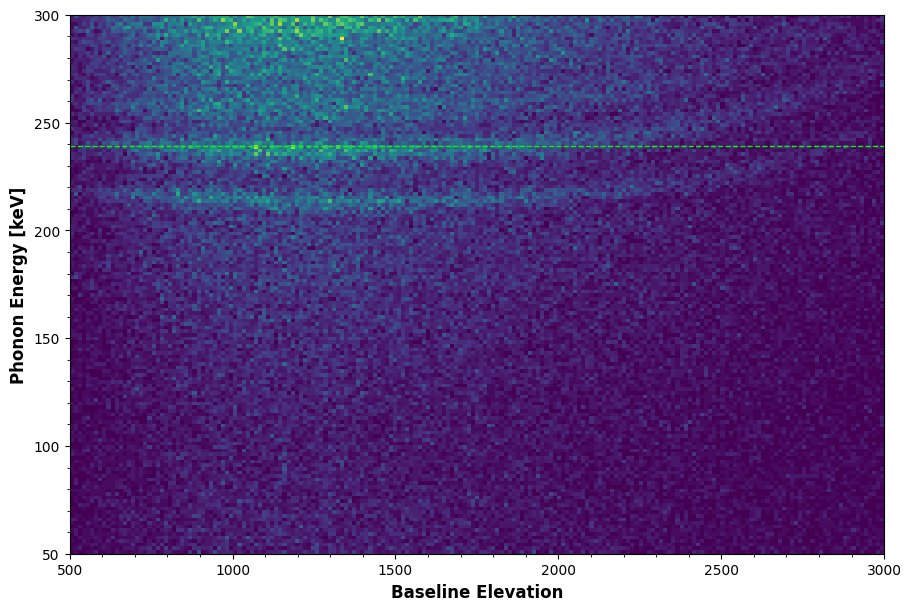

In [82]:
fig = plt.figure()
plt.hist2d(x["PSUMbs"][~x["crand"]]-18000, x["bscorr_man"][~x["crand"]],bins=bins)
plt.axhline(b,linestyle='--',color='lime')
plt.xlabel("Baseline Elevation")
plt.ylabel("Phonon Energy [keV]")
plt.show()

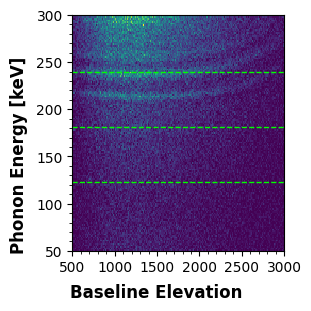

In [83]:
#Plot
n = len(ser); vert = math.ceil(np.sqrt(n)); hor = math.ceil(n/math.ceil(np.sqrt(n)))
fig,ax = plt.subplots(vert,hor,figsize=(3*hor,3*vert),sharey=True)
try:
    for i,axarray in enumerate(ax):
        for j,axis in enumerate(axarray):
            k = j + i*len(axarray)
            if k < len(z): #do nothing if we have an empty corner.
                axis.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['bscorr_man'][~z[k]['crand']],bins=bins)
                axis.axhline(points[0][1],linestyle='--',color='lime')
                axis.axhline(points[1][1],linestyle='--',color='lime')
                axis.axhline(b,linestyle='--',color='lime')
except TypeError: #Case for when there is only one entry.
    if len(z) == 1:
        k = 0 #We could squish z from an array to its entry but that gets complicated later on.
        ax.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['bscorr_man'][~z[k]['crand']],bins=bins)
        ax.axhline(points[0][1],linestyle='--',color='lime')
        ax.axhline(points[1][1],linestyle='--',color='lime')
        ax.axhline(b,linestyle='--',color='lime')
    else:
        raise SizeError("axes could not be enumerated twice but Z had more than one array... fix it nerd!!")
fig.supxlabel("Baseline Elevation"); fig.supylabel("Phonon Energy [keV]")
plt.show()

This cell is for viewing any individual plot; change as desired.

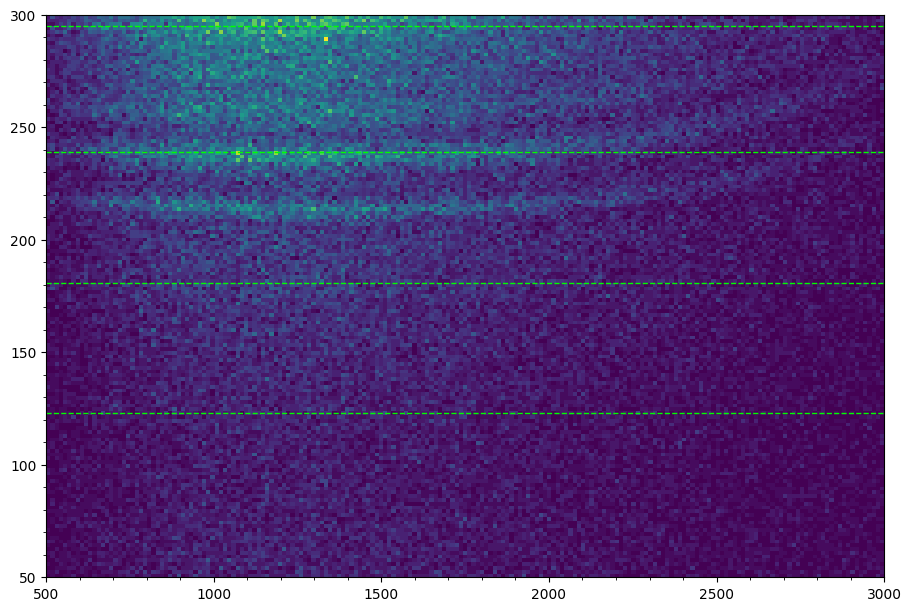

In [84]:
k = 0
fig = plt.figure()
plt.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['bscorr_man'][~z[k]['crand']],bins=bins)
           #bins=[np.linspace(0,2000,200),np.linspace(50,350,150)])
plt.axhline(points[0][1],linestyle='--',color='lime')
plt.axhline(points[1][1],linestyle='--',color='lime')
plt.axhline(b,linestyle='--',color='lime')
plt.axhline(320,linestyle='--',color='lime')
plt.axhline(303,linestyle='--',color='lime')
plt.axhline(295,linestyle='--',color='lime')
plt.show()

### Save or repeat
Either go back up to the "Define points to fit to" section and adjust your points to fix the correction or save the correction information, as printed below, to `baselinecorrectionvalues.csv`.

In [85]:
for series in ser:
    print(series+",",str(m)+",",b)

07221119_1016, -0.058, 239.0
